In [ ]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [ ]:
train_df = pd.read_csv('train_df.csv')
train_df["datetime"] = pd.to_datetime(train_df["datetime"])
train_df = train_df.sort_values(["PORTAL", "datetime"])
train_df

,datetime,PORTAL,FLOW,SPEED_MS_AVG
0,2021-06-01 04:00:00,"E4S 55,620",29.0,21.683103
1,2021-06-01 04:01:00,"E4S 55,620",26.0,21.933077
2,2021-06-01 04:02:00,"E4S 55,620",38.0,21.563684
3,2021-06-01 04:03:00,"E4S 55,620",34.0,22.681176
4,2021-06-01 04:04:00,"E4S 55,620",29.0,23.126552
...,...,...,...,...
528499,2021-11-30 09:56:00,"E4S 58,140",68.0,19.060147
528500,2021-11-30 09:57:00,"E4S 58,140",65.0,20.011385
528501,2021-11-30 09:58:00,"E4S 58,140",57.0,18.898070
528502,2021-11-30 09:59:00,"E4S 58,140",72.0,20.207222


In [ ]:
val_df = pd.read_csv('val_df.csv')
val_df["datetime"] = pd.to_datetime(val_df["datetime"])
val_df = val_df.sort_values(["PORTAL", "datetime"])
val_df

,datetime,PORTAL,FLOW,SPEED_MS_AVG
0,2021-12-01 04:00:00,"E4S 55,620",7.0,21.432857
1,2021-12-01 04:01:00,"E4S 55,620",6.0,21.900000
2,2021-12-01 04:02:00,"E4S 55,620",6.0,18.886667
3,2021-12-01 04:03:00,"E4S 55,620",9.0,21.191111
4,2021-12-01 04:04:00,"E4S 55,620",10.0,21.748000
...,...,...,...,...
89523,2021-12-31 09:56:00,"E4S 58,140",19.0,21.507895
89524,2021-12-31 09:57:00,"E4S 58,140",28.0,20.806071
89525,2021-12-31 09:58:00,"E4S 58,140",23.0,21.352609
89526,2021-12-31 09:59:00,"E4S 58,140",19.0,21.491579


In [ ]:
test_df = pd.read_csv('test_df.csv')
test_df["datetime"] = pd.to_datetime(test_df["datetime"])
test_df = test_df.sort_values(["PORTAL", "datetime"])
test_df

,datetime,PORTAL,FLOW,SPEED_MS_AVG
0,2022-01-01 04:00:00,"E4S 55,620",12.0,21.327500
1,2022-01-01 04:01:00,"E4S 55,620",9.0,22.580000
2,2022-01-01 04:02:00,"E4S 55,620",7.0,22.375714
3,2022-01-01 04:03:00,"E4S 55,620",3.0,22.300000
4,2022-01-01 04:04:00,"E4S 55,620",7.0,23.370000
...,...,...,...,...
522723,2022-06-30 09:56:00,"E4S 58,140",47.0,21.366596
522724,2022-06-30 09:57:00,"E4S 58,140",46.0,21.418696
522725,2022-06-30 09:58:00,"E4S 58,140",57.0,21.047895
522726,2022-06-30 09:59:00,"E4S 58,140",48.0,20.967917


# Feature Engineering

## Portal One-Hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
train_portal = encoder.fit_transform(train_df[["PORTAL"]])
val_portal = encoder.transform(val_df[['PORTAL']])
test_portal = encoder.transform(test_df[['PORTAL']])

portal_cols = list(encoder.get_feature_names_out(['PORTAL']))

train_df[portal_cols] = train_portal
val_df[portal_cols] = val_portal
test_df[portal_cols] = test_portal

## Time-related Features

In [ ]:
def add_time_features(df, start_hour=4, window_minutes=360):
  """
  Add time-related features for 04:00-10:00 data
  Includes:
  - hour, dayofweek, month, is_weekend, minute_since_4am
  - dayofweek_sin, dayofweek_cos, minute_sin, minute_cos, hour_sin, hour_cos
  """
  df["hour"] = df["datetime"].dt.hour
  df["dayofweek"] = df["datetime"].dt.dayofweek
  df["month"] = df["datetime"].dt.month
  df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
  df["minute_since_4am"] = (df["hour"] - start_hour) * 60 + df["datetime"].dt.minute   # 0 ~ 360 min

  # weekly cycle
  df["dayofweek_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
  df["dayofweek_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

  # minutely cycle
  df["minute_sin"] = np.sin(2 * np.pi * df["minute_since_4am"] / window_minutes)
  df["minute_cos"] = np.cos(2 * np.pi * df["minute_since_4am"] / window_minutes)

  # hourly cycle
  df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
  df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

  return df

## Lags & Rolling Features

In [ ]:
SHORT_LAGS = [1, 2, 3, 4, 5, 10, 15, 30, 45, 60]
ROLLING_WINDOWS = [5, 15, 30, 45, 60]

In [ ]:
def add_short_lag_roll_features(df,cols=("FLOW","SPEED_MS_AVG")):
  """
  Add short lags and rolling statistics features per portal for one variable (flow/speed)
  - short lags: t-1, t-2, t-3, t-4, t-5, t-10, t-15, t-30, t-45, t-60 minutes
  - rolling mean/ std: over 5, 15, 30, 45, 60 minutes
  """
  d = df.sort_values(["PORTAL", "datetime"]).copy()
  g = d.groupby("PORTAL")

  for col in cols:
    # short lags
    for lag in SHORT_LAGS:
      d[f"{col}_lag{lag}"] = g[col].shift(lag)

    # rolling stats
    for window in ROLLING_WINDOWS:
      d[f"{col}_rolling_mean{window}"] = g[col].transform(lambda s: s.shift(1).rolling(window, min_periods=max(1, window//3)).mean())
      d[f"{col}_rolling_std{window}"] = g[col].transform(lambda s: s.shift(1).rolling(window, min_periods=max(1, window//3)).std())

  return d

In [ ]:
def add_long_lag_roll_features(df,cols=("FLOW","SPEED_MS_AVG")):
  d = df.copy()
  d["date"] = d["datetime"].dt.date
  d = d.sort_values(["PORTAL","minute_since_4am","date"])
  g = d.groupby(["PORTAL","minute_since_4am"])
  for col in cols:
    d[f"{col}_prevday"] = g[col].shift(1)   # same time the previous day
    d[f"{col}_prevweek"] = g[col].shift(7)   # same time the previous week
    d[f"{col}__roll_mean_3d"] = g[col].transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    d[f"{col}_roll_mean_7d"] = g[col].transform(lambda s: s.shift(1).rolling(7, min_periods=3).mean())
  d.drop(columns=["date"],inplace=True)
  return d

## Spatial Features

In [ ]:
portals = ["E4S 55,620", "E4S 56,160", "E4S 56,490", "E4S 56,780",
       "E4S 57,055", "E4S 57,435", "E4S 57,820", "E4S 58,140"]

def find_upstream_downstream(portals):
  upstream_of = {}
  downstream_of = {}
  for i, portal in enumerate(portals):
    upstream_of[portal] = portals[i+1] if i < len(portals) - 1 else None
    downstream_of[portal] = portals[i-1] if i > 0 else None
  return upstream_of, downstream_of

upstream, downstream = find_upstream_downstream(portals)

In [ ]:
COLS = ("FLOW_lag1","FLOW_lag15","SPEED_MS_AVG_lag1","SPEED_MS_AVG_lag15","FLOW_rolling_mean15", "SPEED_MS_AVG_rolling_mean15")
def add_up_down_features(df,upstream,downstream,cols=COLS):

  d = df.sort_values(["PORTAL","datetime"]).copy()

  d["UP_PORTAL"] = d["PORTAL"].map(upstream)
  d["DOWN_PORTAL"] = d["PORTAL"].map(downstream)

  d_up = d[["PORTAL","datetime",*cols]].rename(columns={col:f"{col}_UP" for col in cols})
  d_down = d[["PORTAL","datetime",*cols]].rename(columns={col:f"{col}_DOWN" for col in cols})

  d = d.merge(d_up,how="left",left_on=["UP_PORTAL","datetime"],right_on=["PORTAL","datetime"]).drop(columns=['PORTAL_y']).rename(columns={'PORTAL_x': 'PORTAL'})
  d = d.merge(d_down,how="left",left_on=["DOWN_PORTAL","datetime"],right_on=["PORTAL","datetime"]).drop(columns=['PORTAL_y']).rename(columns={'PORTAL_x': 'PORTAL'})

  return d

## Target

In [ ]:
HORIZONS = list(range(1,16))

In [ ]:
def make_target(df, horizons=HORIZONS,cols=("FLOW","SPEED_MS_AVG")):
  d = df.sort_values(["PORTAL", "datetime"]).copy()
  g = d.groupby("PORTAL")
  for col in cols:
    for h in horizons:
      d[f"{col}_t+{h}"] = g[col].shift(-h)

  return d

## Combine Features

In [ ]:
def combine_features(df, with_target=True):
  d = df.copy()
  d = add_time_features(d)
  d = add_short_lag_roll_features(d,cols=("FLOW","SPEED_MS_AVG"))
  d = add_long_lag_roll_features(d,cols=("FLOW","SPEED_MS_AVG"))
  d = add_up_down_features(d,upstream,downstream,cols=COLS)
  if with_target:
    d = make_target(d,horizons=HORIZONS,cols=("FLOW","SPEED_MS_AVG"))

  return d

In [ ]:
train_df = combine_features(train_df,with_target=True)
val_df = combine_features(val_df,with_target=True)
test_clean = combine_features(test_df,with_target=True)

In [ ]:
for col in train_df.columns:
  print(col)

datetime
PORTAL
FLOW
SPEED_MS_AVG
PORTAL_E4S 55,620
PORTAL_E4S 56,160
PORTAL_E4S 56,490
PORTAL_E4S 56,780
PORTAL_E4S 57,055
PORTAL_E4S 57,435
PORTAL_E4S 57,820
PORTAL_E4S 58,140
hour
dayofweek
month
is_weekend
minute_since_4am
dayofweek_sin
dayofweek_cos
minute_sin
minute_cos
hour_sin
hour_cos
FLOW_lag1
FLOW_lag2
FLOW_lag3
FLOW_lag4
FLOW_lag5
FLOW_lag10
FLOW_lag15
FLOW_lag30
FLOW_lag45
FLOW_lag60
FLOW_rolling_mean5
FLOW_rolling_std5
FLOW_rolling_mean15
FLOW_rolling_std15
FLOW_rolling_mean30
FLOW_rolling_std30
FLOW_rolling_mean45
FLOW_rolling_std45
FLOW_rolling_mean60
FLOW_rolling_std60
SPEED_MS_AVG_lag1
SPEED_MS_AVG_lag2
SPEED_MS_AVG_lag3
SPEED_MS_AVG_lag4
SPEED_MS_AVG_lag5
SPEED_MS_AVG_lag10
SPEED_MS_AVG_lag15
SPEED_MS_AVG_lag30
SPEED_MS_AVG_lag45
SPEED_MS_AVG_lag60
SPEED_MS_AVG_rolling_mean5
SPEED_MS_AVG_rolling_std5
SPEED_MS_AVG_rolling_mean15
SPEED_MS_AVG_rolling_std15
SPEED_MS_AVG_rolling_mean30
SPEED_MS_AVG_rolling_std30
SPEED_MS_AVG_rolling_mean45
SPEED_MS_AVG_rolling_std45
SPEE

In [ ]:
SHORT_LAGS = [1, 2, 3, 4, 5, 10, 15, 30, 45, 60]
ROLLING_WINDOWS = [5, 15, 30, 45, 60]
HORIZONS = list(range(1,16))

time_features = ["hour","dayofweek","month","is_weekend","minute_since_4am",
          "dayofweek_sin","dayofweek_cos","minute_sin","minute_cos","hour_sin","hour_cos"]

flow_features = (["FLOW"] +
         [f"FLOW_lag{lag}" for lag in SHORT_LAGS] +
         [f"FLOW_rolling_mean{window}" for window in ROLLING_WINDOWS] +
         [f"FLOW_rolling_std{window}" for window in ROLLING_WINDOWS] +
         ["FLOW_prevday","FLOW_prevweek","FLOW__roll_mean_3d","FLOW_roll_mean_7d"] +
         ["FLOW_lag1_UP","FLOW_lag15_UP","FLOW_rolling_mean15_UP"] +
         ["FLOW_lag1_DOWN","FLOW_lag15_DOWN","FLOW_rolling_mean15_DOWN"])

speed_features = (["SPEED_MS_AVG"] +
         [f"SPEED_MS_AVG_lag{lag}" for lag in SHORT_LAGS] +
         [f"SPEED_MS_AVG_rolling_mean{window}" for window in ROLLING_WINDOWS] +
         [f"SPEED_MS_AVG_rolling_std{window}" for window in ROLLING_WINDOWS] +
         ["SPEED_MS_AVG_prevday","SPEED_MS_AVG_prevweek","SPEED_MS_AVG__roll_mean_3d","SPEED_MS_AVG_roll_mean_7d"] +
         ["SPEED_MS_AVG_lag1_UP","SPEED_MS_AVG_lag15_UP","SPEED_MS_AVG_rolling_mean15_UP"] +
         ["SPEED_MS_AVG_lag1_DOWN","SPEED_MS_AVG_lag15_DOWN","SPEED_MS_AVG_rolling_mean15_DOWN"])

X_cols = portal_cols + time_features + flow_features + speed_features
y_flow_cols = [f"FLOW_t+{h}" for h in HORIZONS]
y_speed_cols = [f"SPEED_MS_AVG_t+{h}" for h in HORIZONS]
y_flow_col = y_flow_cols[-1]
y_speed_col = y_speed_cols[-1]

# Training & Val & Test Sets

In [ ]:
X_train = train_df[X_cols]
X_val = val_df[X_cols]
X_test = test_clean[X_cols]
# flow
y_flow_train = train_df.loc[X_train.index, y_flow_col]
y_flow_val = val_df.loc[X_val.index, y_flow_col]
y_flow_test = test_clean.loc[X_test.index, y_flow_col]
# speed
y_speed_train = train_df.loc[X_train.index, y_speed_col]
y_speed_val = val_df.loc[X_val.index, y_speed_col]
y_speed_test = test_clean.loc[X_test.index, y_speed_col]

def drop_nan(X, y):
  mask = ~y.isna()
  return X.loc[mask], y.loc[mask]

X_train, y_flow_train = drop_nan(X_train, y_flow_train)
X_val, y_flow_val = drop_nan(X_val, y_flow_val)
X_test, y_flow_test = drop_nan(X_test, y_flow_test)

X_train, y_speed_train = drop_nan(X_train, y_speed_train)
X_val, y_speed_val = drop_nan(X_val, y_speed_val)
X_test, y_speed_test = drop_nan(X_test, y_speed_test)

# XGBoost

Taking the prediction horizon of 15 minutes, conduct hyperpamameter tunning.

In [ ]:
from xgboost import XGBRegressor

param_grid = {
    "max_depth" : [6, 8, 10],
    "min_child_weight" : [1, 3, 5],
    "subsample" : [0.8, 1.0],
    "colsample_bytree" : [0.8, 1.0],
    "reg_lambda" : [0.5, 1.0, 2.0],
    "reg_alpha" : [0, 0.1, 0.5, 1.0]
}

results = []

for max_depth in param_grid["max_depth"]:
  for min_child_weight in param_grid["min_child_weight"]:
    for subsample in param_grid["subsample"]:
      for colsample_bytree in param_grid["colsample_bytree"]:
        for reg_lambda in param_grid["reg_lambda"]:
          for reg_alpha in param_grid["reg_alpha"]:
            xgb = XGBRegressor(
              n_estimators=3000,
              learning_rate=0.03,
              max_depth=max_depth,
              min_child_weight=min_child_weight,
              subsample=subsample,
              colsample_bytree=colsample_bytree,
              reg_lambda=reg_lambda,
              reg_alpha=reg_alpha,
              objective="reg:squarederror",
              eval_metric="rmse",
              tree_method="hist",
              early_stopping_rounds=100,
              random_state=42,
              n_jobs=-1
            )
            xgb.fit(
              X_train, y_flow_train,
              eval_set=[(X_val, y_flow_val)],
              verbose=False
            )
            best_iter = xgb.best_iteration
            best_score = xgb.best_score
            # print(f"Params: max_depth={max_depth}, min_child_weight={min_child_weight}, subsample={subsample}, "
            #    f"colsample_bytree={colsample_bytree}, reg_lambda={reg_lambda}, reg_alpha={reg_alpha}, "
            #    f"best_iter={best_iter}, best_RMSE={best_score:.4f}")

            results.append({
                "max_depth": max_depth,
                "min_child_weight": min_child_weight,
                "subsample": subsample,
                "colsample_bytree": colsample_bytree,
                "reg_lambda": reg_lambda,
                "reg_alpha": reg_alpha,
                "best_iter": best_iter,
                "best_RMSE": best_score
            })

df_results = pd.DataFrame(results)
df_results.to_csv("xgb_tuning_results.csv", index=False)

In [ ]:
tunning_results = pd.read_csv("xgb_tuning_results.csv")
tunning_results.sort_values("best_RMSE")

,max_depth,min_child_weight,subsample,colsample_bytree,reg_lambda,reg_alpha,best_iter,best_RMSE
31,6,1,1.0,0.8,1.0,1.0,420,7.762011
99,6,5,0.8,0.8,0.5,1.0,372,7.762780
25,6,1,1.0,0.8,0.5,0.1,441,7.765135
56,6,3,0.8,0.8,2.0,0.0,332,7.765185
9,6,1,0.8,0.8,2.0,0.1,333,7.767051
...,...,...,...,...,...,...,...,...
312,10,1,1.0,0.8,0.5,0.0,260,7.911328
426,10,5,1.0,1.0,1.0,0.5,189,7.911624
415,10,5,1.0,0.8,1.0,1.0,196,7.912783
371,10,3,1.0,0.8,2.0,1.0,181,7.913654


In [ ]:
tuning_results = pd.read_csv("xgb_tuning_results.csv")
best = tuning_results.sort_values("best_RMSE").iloc[0]

best_params = dict(
    max_depth=int(best.max_depth),
    min_child_weight=int(best.min_child_weight),
    subsample=float(best.subsample),
    colsample_bytree=float(best.colsample_bytree),
    reg_lambda=float(best.reg_lambda),
    reg_alpha=float(best.reg_alpha),
    n_estimators=int(best.best_iter)
)

# combine train & val for the final train
X_final = pd.concat([X_train, X_val], axis=0)
y_flow_final = pd.concat([y_flow_train, y_flow_val], axis=0)

xgb_flow = XGBRegressor(
    learning_rate=0.03,
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    **best_params
)
xgb_flow.fit(X_final, y_flow_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=420,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
pred_flow = xgb_flow.predict(X_test)
mae = mean_absolute_error(y_flow_test, pred_flow)
rmse = root_mean_squared_error(y_flow_test, pred_flow)
print(f"FLOW +15min  MAE={mae:.3f}  RMSE={rmse:.3f}")

FLOW +15min  MAE=6.555  RMSE=9.012


# Flow Prediction - Future 15 minutes

In [ ]:
tuning_results = pd.read_csv("xgb_tuning_results.csv")
best = tuning_results.sort_values("best_RMSE").iloc[0]

In [ ]:
HORIZONS = list(range(1,16))

X_cols = portal_cols + time_features + flow_features + speed_features

X_train_base = train_df[X_cols]
X_val_base = val_df[X_cols]
X_test_base = test_clean[X_cols]

def drop_nan(X, y):
  mask = ~y.isna()
  return X.loc[mask], y.loc[mask]

flow_results = []
flow_preds = {}

# Using train&val data to get the best iteration
best_params = dict(
  max_depth=int(best.max_depth),
  min_child_weight=int(best.min_child_weight),
  subsample=float(best.subsample),
  colsample_bytree=float(best.colsample_bytree),
  reg_lambda=float(best.reg_lambda),
  reg_alpha=float(best.reg_alpha),
)

for h in HORIZONS:
  y_flow_col = f"FLOW_t+{h}"

  X_train = X_train_base.copy()
  X_val = X_val_base.copy()
  X_test = X_test_base.copy()

  # flow
  y_flow_train = train_df.loc[X_train.index, y_flow_col]
  y_flow_val = val_df.loc[X_val.index, y_flow_col]
  y_flow_test = test_clean.loc[X_test.index, y_flow_col]

  X_train, y_flow_train = drop_nan(X_train, y_flow_train)
  X_val, y_flow_val = drop_nan(X_val, y_flow_val)
  X_test, y_flow_test = drop_nan(X_test, y_flow_test)


  xgb_tmp = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="hist",
    early_stopping_rounds=100,
    random_state=42,
    n_jobs=-1,
    **best_params)

  xgb_tmp.fit(X_train, y_flow_train, eval_set=[(X_val, y_flow_val)], verbose=False)
  best_iter = xgb_tmp.best_iteration
  print(f"Best iteration: {best_iter}")

  # Combine train&val data, using best iteration and other best params to train final model
  X_final = pd.concat([X_train, X_val], axis=0)
  y_flow_final = pd.concat([y_flow_train, y_flow_val], axis=0)

  xgb_flow = XGBRegressor(
    n_estimators=best_iter,
    learning_rate=0.03,
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    **best_params
    )
  xgb_flow.fit(X_final, y_flow_final)

  # save model
  model_path = f"xgb_flow_model_h{h}.pkl"
  joblib.dump(xgb_flow, model_path)
  print(f"Saved model for horizon {h} → {model_path}")

  # final test
  pred_flow = xgb_flow.predict(X_test)
  mae = mean_absolute_error(y_flow_test, pred_flow)
  rmse = root_mean_squared_error(y_flow_test, pred_flow)
  print(f"FLOW +{h}min  MAE={mae:.3f}  RMSE={rmse:.3f}")

  flow_results.append({"horizon": h, "MAE": mae, "RMSE": rmse})
  flow_preds[h] = pd.Series(pred_flow, index=y_flow_test.index, name=f"pred_t+{h}")

  flow_results_df = pd.DataFrame(flow_results)
  flow_results_df.to_csv("xgb_flow_evaluation_results.csv", index=False)

  flow_preds_df = pd.concat(flow_preds, axis=1)
  flow_preds_df.columns = [f"pred_t+{h}" for h in flow_preds.keys()]
  flow_preds_df.to_csv("xgb_flow_preds.csv")

#### Add noise

In [ ]:
def add_gaussian_noise(df, cols, sigma_ratio=0.2, random_state=42):
  """
  Add Gaussian noise to the specified column： N(0, sigma^2)，sigma = sigma_ratio * std(col)
  """
  np.random.seed(random_state)
  df_noisy = df.copy()
  for col in cols:
    std = df[col].std()
    noise = np.random.normal(0, sigma_ratio * std, size=len(df))
    df_noisy[col] = np.clip(df[col] + noise, 0, None)  # prevent negative values
  return df_noisy

In [ ]:
gaussian_sigmas = [0.2, 0.4, 0.8, 1.0, 2.0]

In [ ]:
tuning_results = pd.read_csv("xgb_tuning_results.csv")
best = tuning_results.sort_values("best_RMSE").iloc[0]

In [ ]:
HORIZONS = list(range(1,16))

X_train_base = train_df[X_cols]
X_val_base = val_df[X_cols]
X_test_base = test_clean[X_cols]

def drop_nan(X, y):
  mask = ~y.isna()
  return X.loc[mask], y.loc[mask]

flow_results = []
flow_preds = {}
NOISE_CSV = "xgb_flow_noise_results.csv"

# Using train&val data to get the best iteration
best_params = dict(
  max_depth=int(best.max_depth),
  min_child_weight=int(best.min_child_weight),
  subsample=float(best.subsample),
  colsample_bytree=float(best.colsample_bytree),
  reg_lambda=float(best.reg_lambda),
  reg_alpha=float(best.reg_alpha),
)

for h in HORIZONS:
  y_flow_col = f"FLOW_t+{h}"

  X_train = X_train_base.copy()
  X_val = X_val_base.copy()
  X_test = X_test_base.copy()

  # flow
  y_flow_train = train_df.loc[X_train.index, y_flow_col]
  y_flow_val = val_df.loc[X_val.index, y_flow_col]
  y_flow_test = test_clean.loc[X_test.index, y_flow_col]

  X_train, y_flow_train = drop_nan(X_train, y_flow_train)
  X_val, y_flow_val = drop_nan(X_val, y_flow_val)
  X_test, y_flow_test = drop_nan(X_test, y_flow_test)


  xgb_tmp = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="hist",
    early_stopping_rounds=100,
    random_state=42,
    n_jobs=-1,
    **best_params)

  xgb_tmp.fit(X_train, y_flow_train, eval_set=[(X_val, y_flow_val)], verbose=False)
  best_iter = xgb_tmp.best_iteration
  print(f"Best iteration: {best_iter}")

  # Combine train&val data, using best iteration and other best params to train final model
  X_final = pd.concat([X_train, X_val], axis=0)
  y_flow_final = pd.concat([y_flow_train, y_flow_val], axis=0)

  xgb_flow = XGBRegressor(
    n_estimators=best_iter,
    learning_rate=0.03,
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    **best_params
    )
  xgb_flow.fit(X_final, y_flow_final)

  # final test
  pred_flow = xgb_flow.predict(X_test)
  mae_clean = mean_absolute_error(y_flow_test, pred_flow)
  rmse_clean = root_mean_squared_error(y_flow_test, pred_flow)
  print(f"FLOW +{h}min  MAE={mae_clean:.3f}  RMSE={rmse_clean:.3f}")

  flow_results.append({"horizon": h, "MAE": mae_clean, "RMSE": rmse_clean})
  flow_preds[h] = pd.Series(pred_flow, index=y_flow_test.index, name=f"pred_t+{h}")

  flow_results_df = pd.DataFrame(flow_results)
  flow_results_df.to_csv("xgb_flow_evaluation_results.csv", index=False)

  flow_preds_df = pd.concat(flow_preds, axis=1)
  flow_preds_df.columns = [f"pred_t+{h}" for h in flow_preds.keys()]
  flow_preds_df.to_csv("xgb_flow_preds.csv")

  noise_results = []
  for sigma in gaussian_sigmas:
    test_gaussian_noisy = test_df.copy()
    test_gaussian_noisy = add_gaussian_noise(
        test_gaussian_noisy, cols=("FLOW", "SPEED_MS_AVG"), sigma_ratio=sigma
    )

    test_gaussian_noisy[portal_cols] = encoder.transform(test_gaussian_noisy[['PORTAL']])

    # recreate input features with noisy
    test_gnoisy = combine_features(test_gaussian_noisy, with_target=False)

    X_test_gnoisy = test_gnoisy.reindex(X_test.index)[X_cols]

    # final test
    pred_flow_gnoisy = xgb_flow.predict(X_test_gnoisy)
    mae_g = mean_absolute_error(y_flow_test, pred_flow_gnoisy)
    rmse_g = root_mean_squared_error(y_flow_test, pred_flow_gnoisy)
    print(f"GNOISE-FLOW +{h}min  MAE={mae_g:.3f}  RMSE={rmse_g:.3f}")
    noise_results.append({
        "horizon": h, "type": "Gaussian", "level": sigma,
        "MAE": mae_g, "RMSE": rmse_g,
        "dMAE%": 100 * (mae_g - mae_clean) / mae_clean,
        "dRMSE%": 100 * (rmse_g - rmse_clean) / rmse_clean
    })

  noise_df = pd.DataFrame(noise_results)
  noise_df.to_csv(
      NOISE_CSV,
      mode="a",
      index=False,
      header=not os.path.exists(NOISE_CSV)
  )

# Speed Prediction - Future 15 minutes

In [ ]:
HORIZONS = list(range(1,16))

X_cols = portal_cols + time_features + flow_features + speed_features

X_train_base = train_df[X_cols]
X_val_base = val_df[X_cols]
X_test_base = test_clean[X_cols]

def drop_nan(X, y):
  mask = ~y.isna()
  return X.loc[mask], y.loc[mask]

speed_results = []
speed_preds = {}

best_params = dict(
  max_depth=int(best.max_depth),
  min_child_weight=int(best.min_child_weight),
  subsample=float(best.subsample),
  colsample_bytree=float(best.colsample_bytree),
  reg_lambda=float(best.reg_lambda),
  reg_alpha=float(best.reg_alpha),
)

for h in HORIZONS:
  y_speed_col = f"SPEED_MS_AVG_t+{h}"

  X_train = X_train_base.copy()
  X_val = X_val_base.copy()
  X_test = X_test_base.copy()

  # speed
  y_speed_train = train_df.loc[X_train.index, y_speed_col]
  y_speed_val = val_df.loc[X_val.index, y_speed_col]
  y_speed_test = test_clean.loc[X_test.index, y_speed_col]

  X_train, y_speed_train = drop_nan(X_train, y_speed_train)
  X_val, y_speed_val = drop_nan(X_val, y_speed_val)
  X_test, y_speed_test = drop_nan(X_test, y_speed_test)

  xgb_tmp = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="hist",
    early_stopping_rounds=100,
    random_state=42,
    n_jobs=-1,
    **best_params)

  xgb_tmp.fit(X_train, y_speed_train, eval_set=[(X_val, y_speed_val)], verbose=False)
  best_iter = xgb_tmp.best_iteration
  print(f"Best iteration: {best_iter}")

  # Combine train&val data, using best iteration and other best params to train final model
  X_final = pd.concat([X_train, X_val], axis=0)
  y_speed_final = pd.concat([y_speed_train, y_speed_val], axis=0)

  xgb_speed = XGBRegressor(
    n_estimators=best_iter,
    learning_rate=0.03,
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    **best_params
    )
  xgb_speed.fit(X_final, y_speed_final)

  # save model
  model_path = f"xgb_speed_model_h{h}.pkl"
  joblib.dump(xgb_speed, model_path)
  print(f"Saved model for horizon {h} → {model_path}")

  # final test
  pred_speed = xgb_speed.predict(X_test)
  mae = mean_absolute_error(y_speed_test, pred_speed)
  rmse = root_mean_squared_error(y_speed_test, pred_speed)
  print(f"SPEED+{h}min  MAE={mae:.3f}  RMSE={rmse:.3f}")

  speed_results.append({"horizon": h, "MAE": mae, "RMSE": rmse})
  speed_preds[h] = pd.Series(pred_speed, index=y_speed_test.index, name=f"pred_t+{h}")

  speed_results_df = pd.DataFrame(speed_results)
  speed_results_df.to_csv("xgb_speed_evaluation_results.csv", index=False)

  speed_preds_df = pd.concat(speed_preds, axis=1)
  speed_preds_df.columns = [f"pred_t+{h}" for h in speed_preds.keys()]
  speed_preds_df.to_csv("xgb_speed_preds.csv")

In [ ]:
xgb_flow = pd.read_csv("xgb_flow_evaluation_results.csv", index_col=0)
xgb_speed = pd.read_csv("xgb_speed_evaluation_results.csv", index_col=0)

In [ ]:
xgb_flow

,MAE,RMSE
horizon,,
1,5.757869,7.909513
2,5.830362,8.047973
3,5.890814,8.142880
4,5.917559,8.171784
5,5.947459,8.150722
6,6.024600,8.330513
7,6.108060,8.441999
8,6.126229,8.451580
9,6.166465,8.481686


In [ ]:
xgb_speed

,MAE,RMSE
horizon,,
1,0.669077,0.970639
2,0.695395,1.048051
3,0.711919,1.100720
4,0.726374,1.153728
5,0.738664,1.192549
6,0.751354,1.235862
7,0.759689,1.263092
8,0.769217,1.293002
9,0.780864,1.329001


## Add noise

In [ ]:
HORIZONS = list(range(1,16))

X_train_base = train_df[X_cols]
X_val_base = val_df[X_cols]
X_test_base = test_clean[X_cols]

def drop_nan(X, y):
  mask = ~y.isna()
  return X.loc[mask], y.loc[mask]

speed_results = []
speed_preds = {}
NOISE_SPEED_CSV = "xgb_speed_noise_results.csv"
# Using train&val data to get the best iteration
best_params = dict(
  max_depth=int(best.max_depth),
  min_child_weight=int(best.min_child_weight),
  subsample=float(best.subsample),
  colsample_bytree=float(best.colsample_bytree),
  reg_lambda=float(best.reg_lambda),
  reg_alpha=float(best.reg_alpha),
)

for h in HORIZONS:
  y_speed_col = f"SPEED_MS_AVG_t+{h}"

  X_train = X_train_base.copy()
  X_val = X_val_base.copy()
  X_test = X_test_base.copy()

  # flow
  y_speed_train = train_df.loc[X_train.index, y_speed_col]
  y_speed_val = val_df.loc[X_val.index, y_speed_col]
  y_speed_test = test_clean.loc[X_test.index, y_speed_col]

  X_train, y_speed_train = drop_nan(X_train, y_speed_train)
  X_val, y_speed_val = drop_nan(X_val, y_speed_val)
  X_test, y_speed_test = drop_nan(X_test, y_speed_test)


  xgb_tmp = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="hist",
    early_stopping_rounds=100,
    random_state=42,
    n_jobs=-1,
    **best_params)

  xgb_tmp.fit(X_train, y_speed_train, eval_set=[(X_val, y_speed_val)], verbose=False)
  best_iter = xgb_tmp.best_iteration
  print(f"Best iteration: {best_iter}")

  # Combine train&val data, using best iteration and other best params to train final model
  X_final = pd.concat([X_train, X_val], axis=0)
  y_speed_final = pd.concat([y_speed_train, y_speed_val], axis=0)

  xgb_speed = XGBRegressor(
    n_estimators=best_iter,
    learning_rate=0.03,
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    **best_params
    )
  xgb_speed.fit(X_final, y_speed_final)

  # final test
  pred_speed= xgb_speed.predict(X_test)
  mae_clean = mean_absolute_error(y_speed_test, pred_speed)
  rmse_clean = root_mean_squared_error(y_speed_test, pred_speed)
  print(f"SPEED +{h}min  MAE={mae_clean:.3f}  RMSE={rmse_clean:.3f}")

  speed_results.append({"horizon": h, "MAE": mae_clean, "RMSE": rmse_clean})
  speed_preds[h] = pd.Series(pred_speed, index=y_speed_test.index, name=f"pred_t+{h}")

  speed_results_df = pd.DataFrame(speed_results)
  speed_results_df.to_csv("xgb_speed_evaluation_results.csv", index=False)

  speed_preds_df = pd.concat(speed_preds, axis=1)
  speed_preds_df.columns = [f"pred_t+{h}" for h in speed_preds.keys()]
  speed_preds_df.to_csv("xgb_speed_preds.csv")

  noise_results = []
  for sigma in gaussian_sigmas:
    test_gaussian_noisy = test_df.copy()
    test_gaussian_noisy = add_gaussian_noise(
        test_gaussian_noisy, cols=("FLOW", "SPEED_MS_AVG"), sigma_ratio=sigma
    )

    test_gaussian_noisy[portal_cols] = encoder.transform(test_gaussian_noisy[['PORTAL']])

    # recreate input features with noisy
    test_gnoisy = combine_features(test_gaussian_noisy, with_target=False)

    X_test_gnoisy = test_gnoisy.reindex(X_test.index)[X_cols]

    # final test
    pred_speed_gnoisy = xgb_speed.predict(X_test_gnoisy)
    mae_g = mean_absolute_error(y_speed_test, pred_speed_gnoisy)
    rmse_g = root_mean_squared_error(y_speed_test, pred_speed_gnoisy)
    print(f"GNOISE-SPEED +{h}min  MAE={mae_g:.3f}  RMSE={rmse_g:.3f}")
    noise_results.append({
        "horizon": h, "type": "Gaussian", "level": sigma,
        "MAE": mae_g, "RMSE": rmse_g,
        "dMAE%": 100 * (mae_g - mae_clean) / mae_clean,
        "dRMSE%": 100 * (rmse_g - rmse_clean) / rmse_clean
    })

  noise_df = pd.DataFrame(noise_results)
  noise_df.to_csv(
      NOISE_SPEED_CSV,
      mode="a",
      index=False,
      header=not os.path.exists(NOISE_SPEED_CSV)
  )

# Visualization

## Errors vs. Horizons

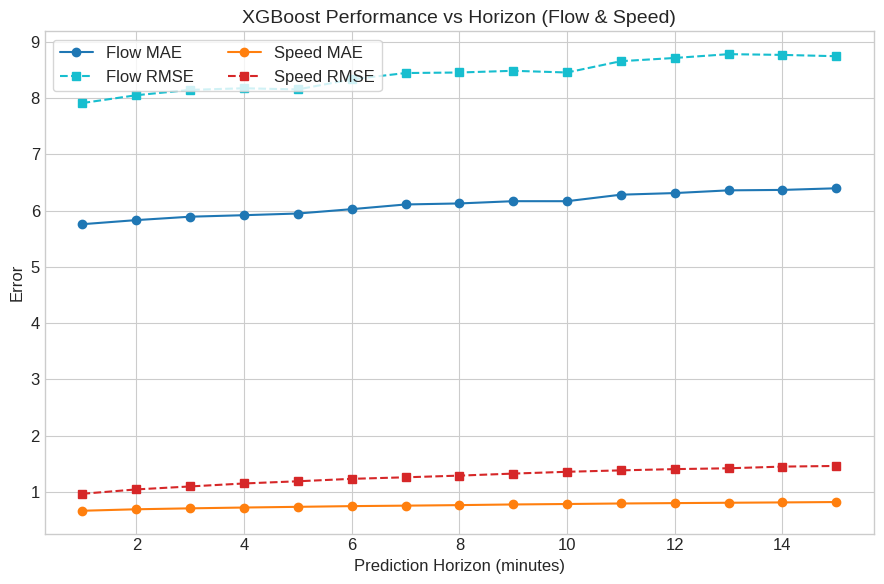

In [ ]:
flow_results = pd.read_csv("xgb_flow_evaluation_results.csv")
speed_results = pd.read_csv("xgb_speed_evaluation_results.csv")

# === 2. Figure style ===
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "figure.figsize": (9,6),
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.frameon": True,
})

# === 3. Plot ===
fig, ax = plt.subplots()

# FLOW curves
ax.plot(flow_results["horizon"], flow_results["MAE"], "o-", color="tab:blue", label="Flow MAE")
ax.plot(flow_results["horizon"], flow_results["RMSE"], "s--", color="tab:cyan", label="Flow RMSE")

# SPEED curves
ax.plot(speed_results["horizon"], speed_results["MAE"], "o-", color="tab:orange", label="Speed MAE")
ax.plot(speed_results["horizon"], speed_results["RMSE"], "s--", color="tab:red", label="Speed RMSE")

# Labels
ax.set_xlabel("Prediction Horizon (minutes)")
ax.set_ylabel("Error")
ax.set_title("XGBoost Performance vs Horizon (Flow & Speed)")
ax.legend(loc="upper left", ncol=2)
plt.tight_layout()
plt.show()

## True Values vs. Predictions

In [ ]:
def aligned_pair(test_df, preds_df, target, h):

    y_col = f"{target}_t+{h}"
    p_col = f"pred_t+{h}"

    df = test_clean[["datetime", "PORTAL", y_col]].join(preds_df[[p_col]], how="inner")
    df = df.dropna(subset=[y_col, p_col])

    return df

In [ ]:
HORIZONS = list(range(1,16))
flow_preds = pd.read_csv("xgb_flow_preds.csv", index_col=0)
speed_preds = pd.read_csv("xgb_speed_preds.csv", index_col=0)

flow_pairs = {}
for h in HORIZONS:
  flow_pairs[h] = aligned_pair(test_clean, flow_preds, target="FLOW", h=h)

speed_pairs = {}
for h in HORIZONS:
  speed_pairs[h] = aligned_pair(test_clean, speed_preds, target="SPEED_MS_AVG", h=h)

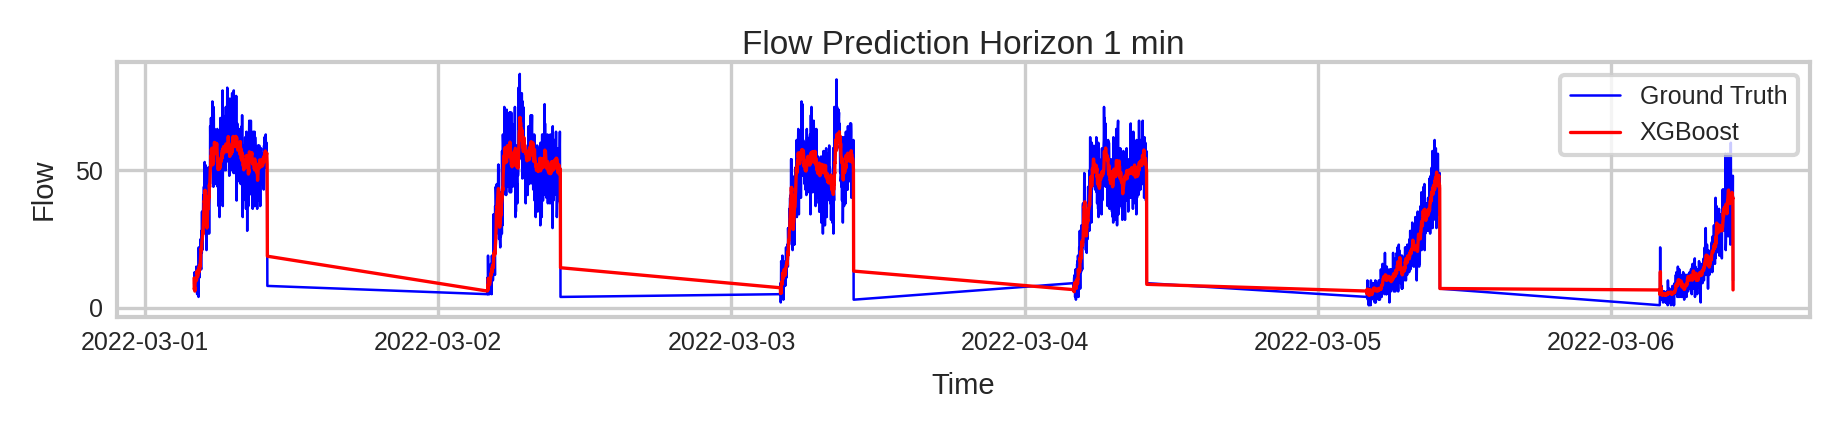

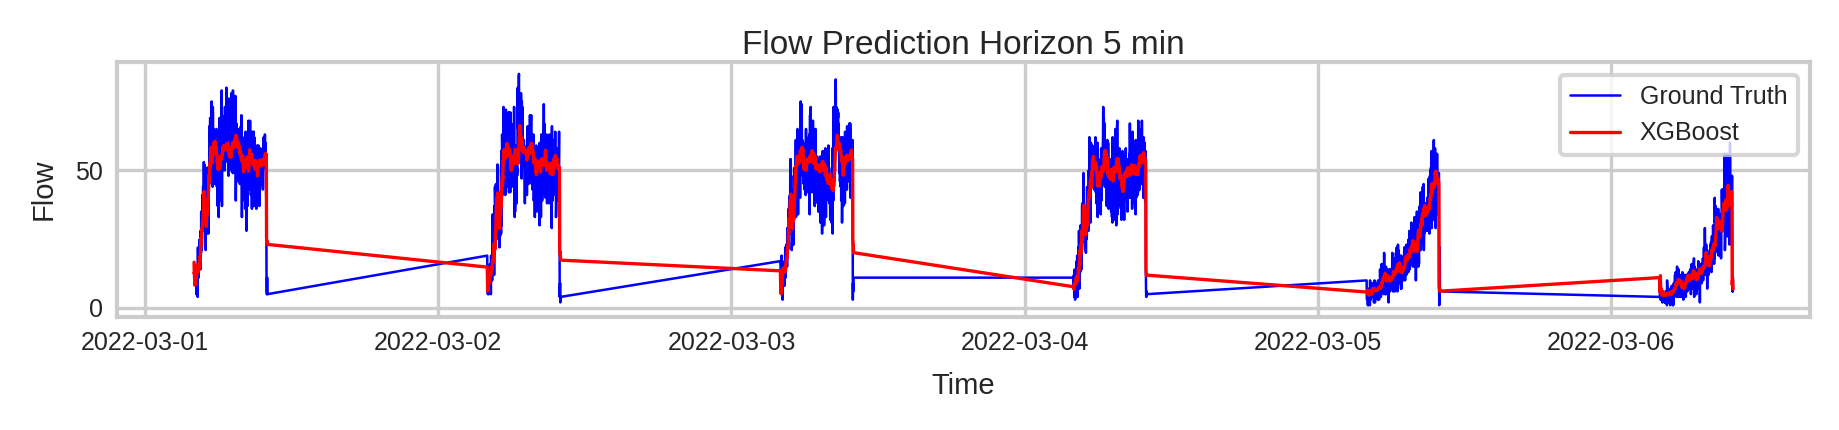

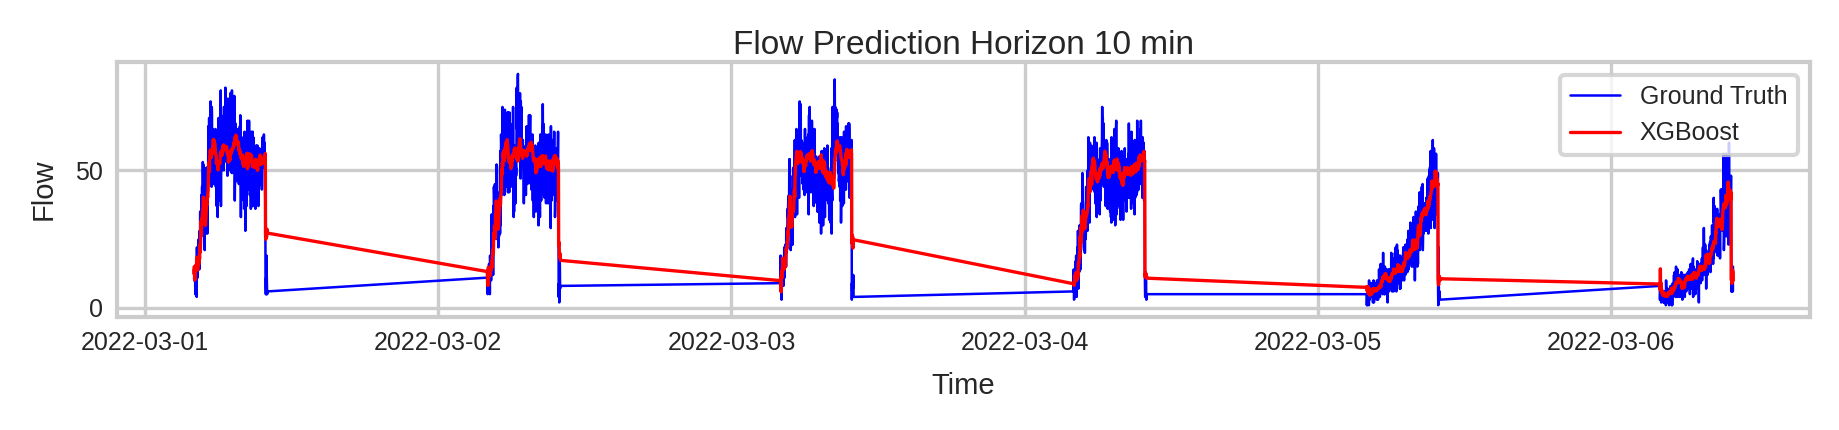

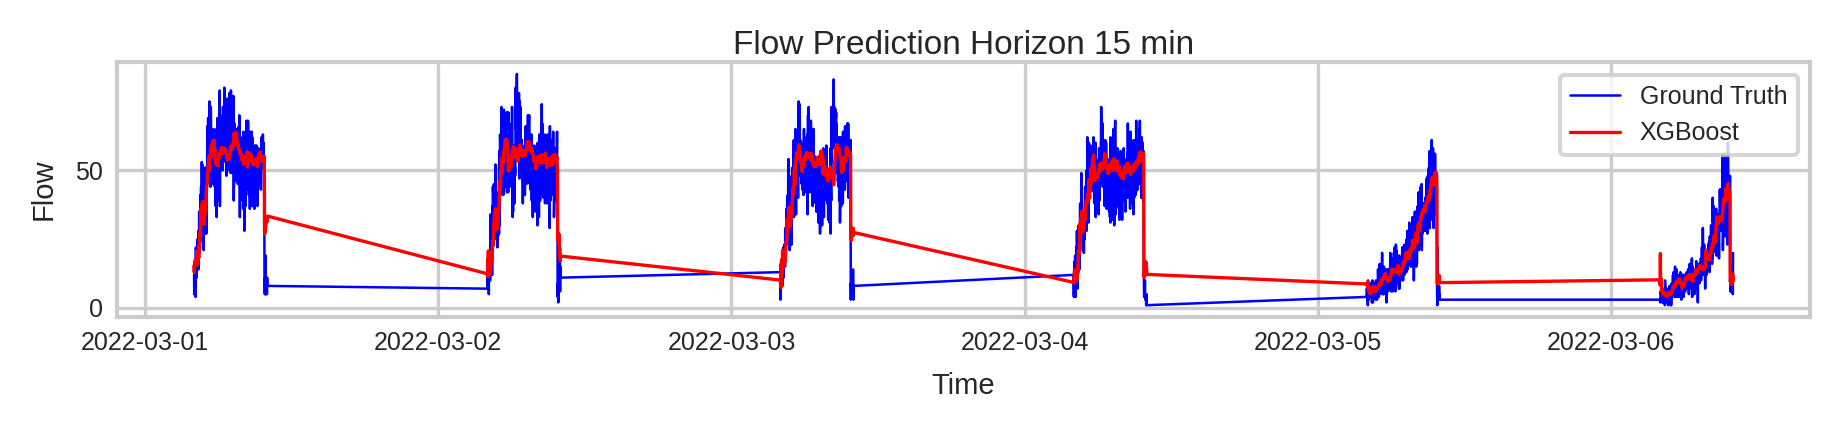

In [ ]:
import matplotlib.pyplot as plt

H = [1, 5, 10, 15]
portal_id = "E4S 56,160"

for h in H:
    df = flow_pairs[h]
    df = df[df["PORTAL"] == portal_id]

    mask = (df["datetime"] >= "2022-03-01") & (df["datetime"] < "2022-03-07")
    df_sub = df.loc[mask]

    plt.figure(figsize=(6, 1.3), dpi=300)
    plt.plot(df_sub["datetime"], df_sub[f"FLOW_t+{h}"].values,
             label="Ground Truth", linewidth=0.6, color="blue")
    plt.plot(df_sub["datetime"], df_sub[f"pred_t+{h}"].values,
             label="XGBoost", linewidth=0.8, color="red")

    plt.ylabel("Flow", fontsize=7)
    plt.xlabel("Time", fontsize=7)
    plt.xticks(fontsize=6, rotation=0)
    plt.yticks(fontsize=6)
    plt.legend(fontsize=6, loc="upper right", frameon=True)

    plt.title(f"Flow Prediction Horizon {h} min", fontsize=8, pad=2)
    plt.tight_layout(pad=0.2)
    plt.show()

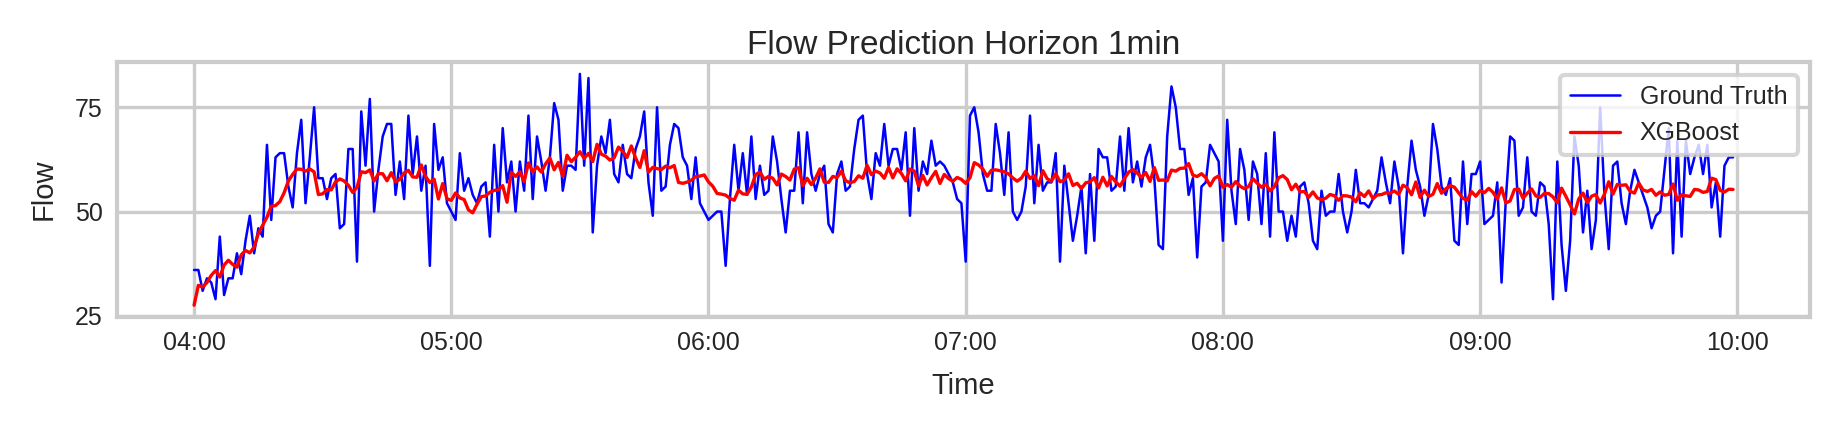

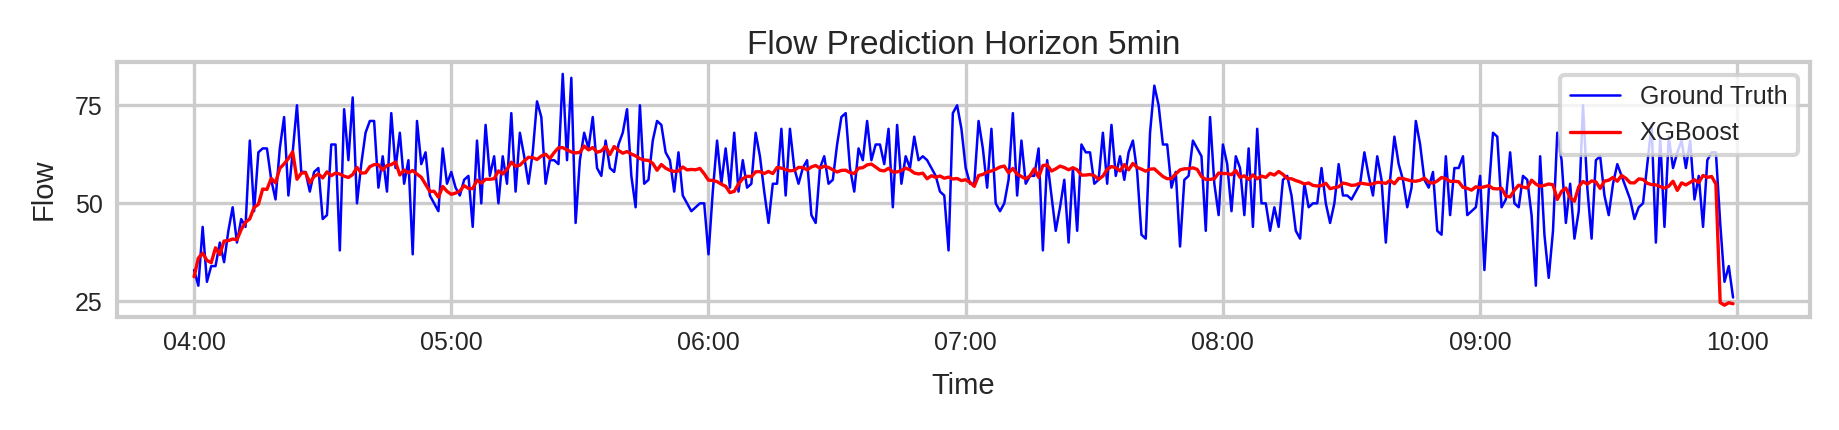

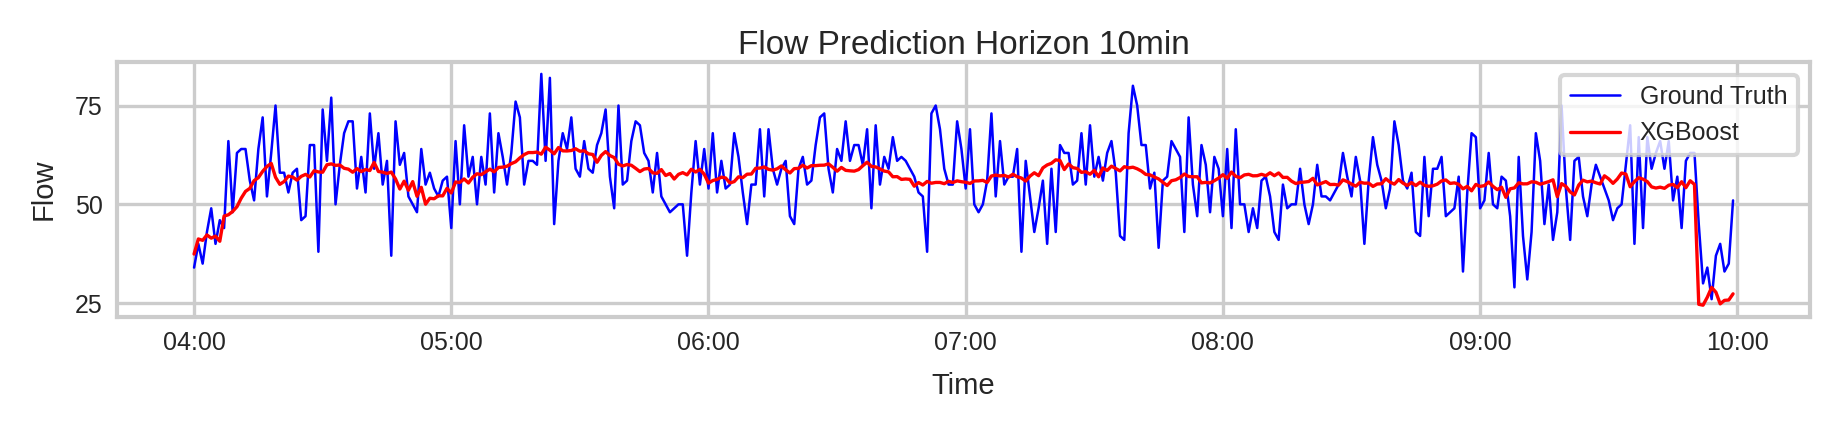

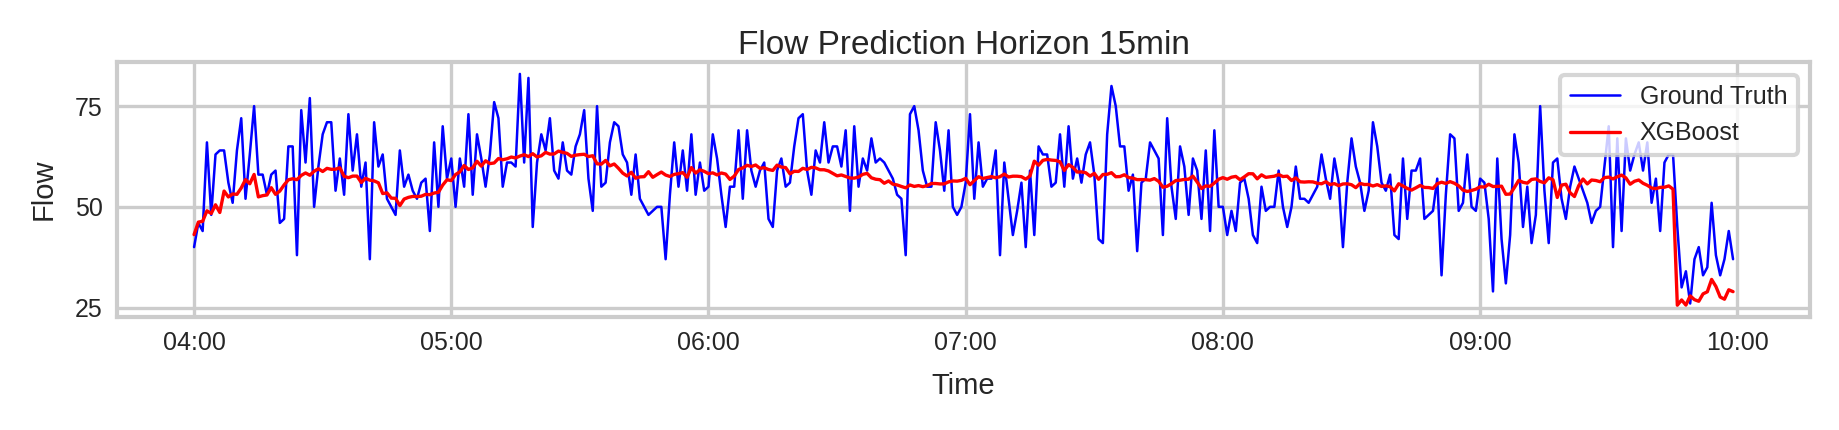

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator

H = [1, 5, 10, 15]
portal_id = "E4S 56,160"

for h in H:
    df = flow_pairs[h]
    df = df[df["PORTAL"] == portal_id]

    # random day
    mask = (df["datetime"] >= "2022-04-20 04:00:00") & (df["datetime"] < "2022-04-20 10:00:00")
    df_sub = df.loc[mask]

    plt.figure(figsize=(6, 1.3), dpi=300)
    plt.plot(df_sub["datetime"], df_sub[f"FLOW_t+{h}"].values, label="Ground Truth", linewidth=0.6, color="blue")
    plt.plot(df_sub["datetime"], df_sub[f"pred_t+{h}"].values, label="XGBoost", linewidth=0.8, color="red")

    plt.ylabel("Flow", fontsize=7)
    plt.xlabel("Time", fontsize=7)
    plt.yticks(fontsize=6)

    plt.gca().xaxis.set_major_locator(HourLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(DateFormatter("%H:%M"))
    plt.xticks(fontsize=6, rotation=0)

    plt.legend(fontsize=6, loc="upper right", frameon=True)
    plt.title(f"Flow Prediction Horizon {h}min", fontsize=8, pad=2)

    plt.tight_layout(pad=0.2)
    plt.show()

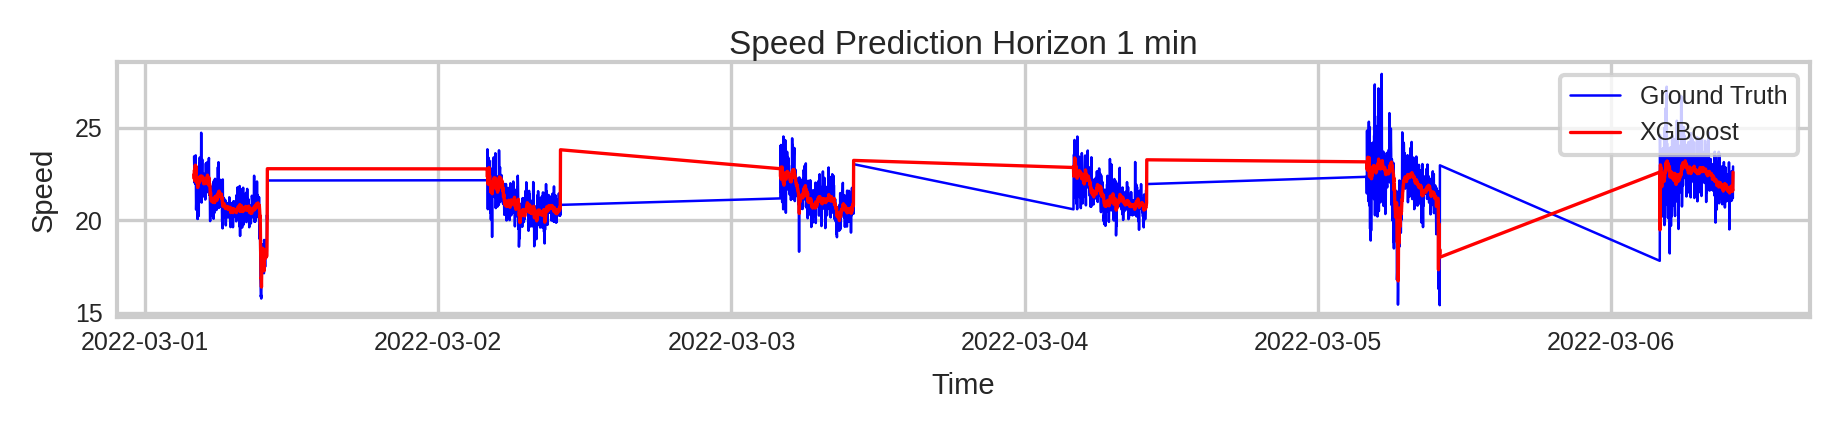

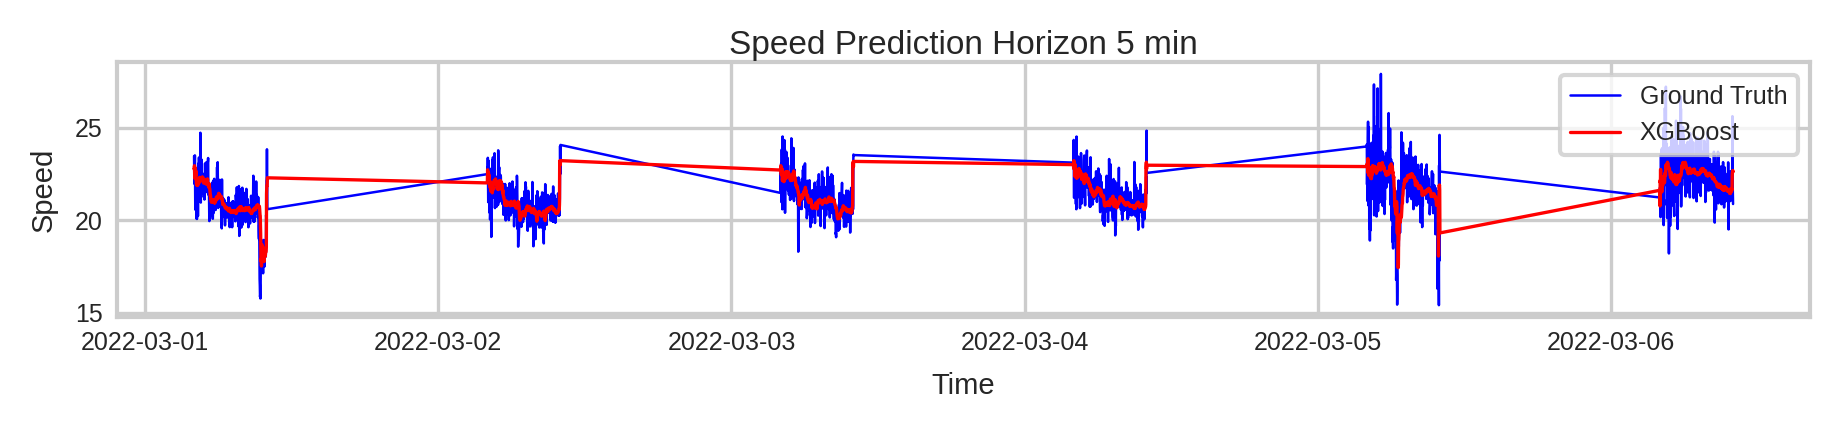

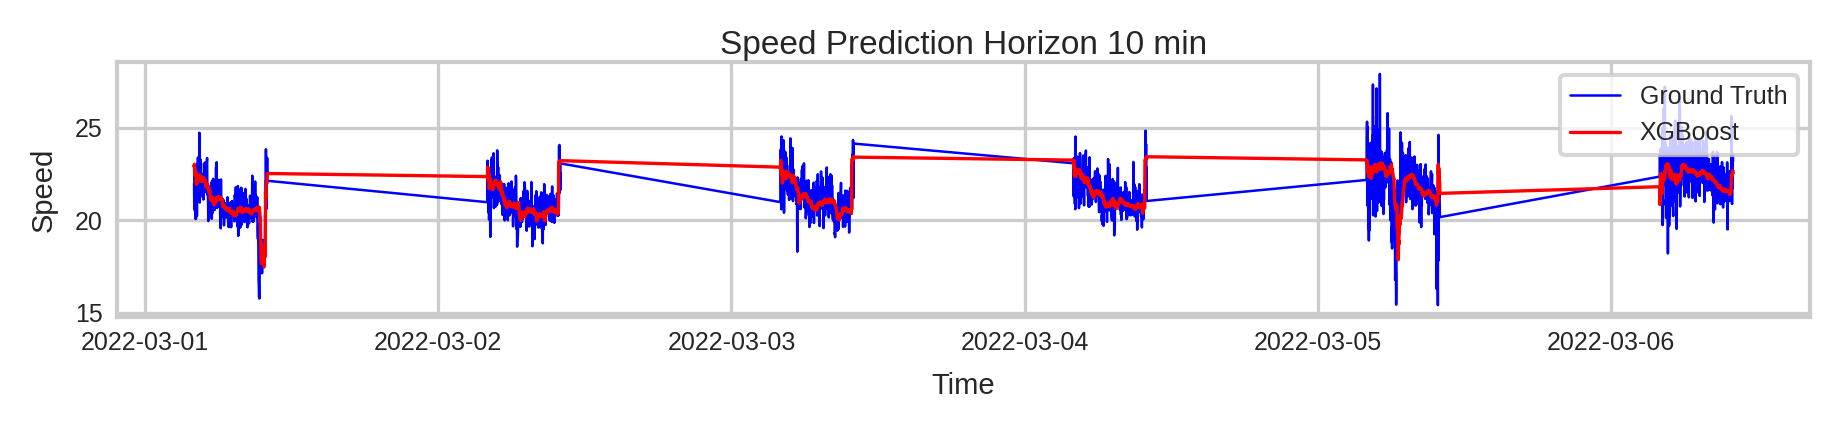

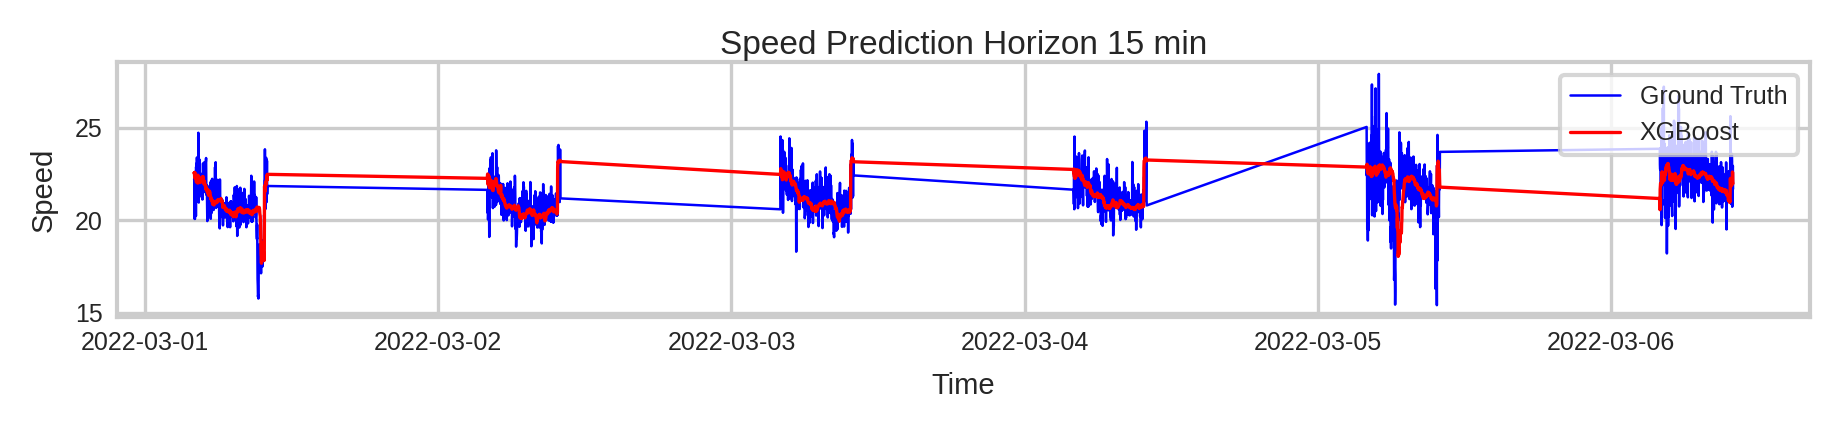

In [ ]:
import matplotlib.pyplot as plt

H = [1, 5, 10, 15]
portal_id = "E4S 56,160"

for h in H:
    df = speed_pairs[h]
    df = df[df["PORTAL"] == portal_id]

    mask = (df["datetime"] >= "2022-03-01") & (df["datetime"] < "2022-03-07")
    df_sub = df.loc[mask]

    plt.figure(figsize=(6, 1.3), dpi=300)
    plt.plot(df_sub["datetime"], df_sub[f"SPEED_MS_AVG_t+{h}"].values, label="Ground Truth", linewidth=0.6, color="blue")
    plt.plot(df_sub["datetime"], df_sub[f"pred_t+{h}"].values, label="XGBoost", linewidth=0.8, color="red")

    plt.ylabel("Speed", fontsize=7)
    plt.xlabel("Time", fontsize=7)
    plt.xticks(fontsize=6, rotation=0)
    plt.yticks(fontsize=6)
    plt.legend(fontsize=6, loc="upper right", frameon=True)

    plt.title(f"Speed Prediction Horizon {h} min", fontsize=8, pad=2)
    plt.tight_layout(pad=0.2)
    plt.show()

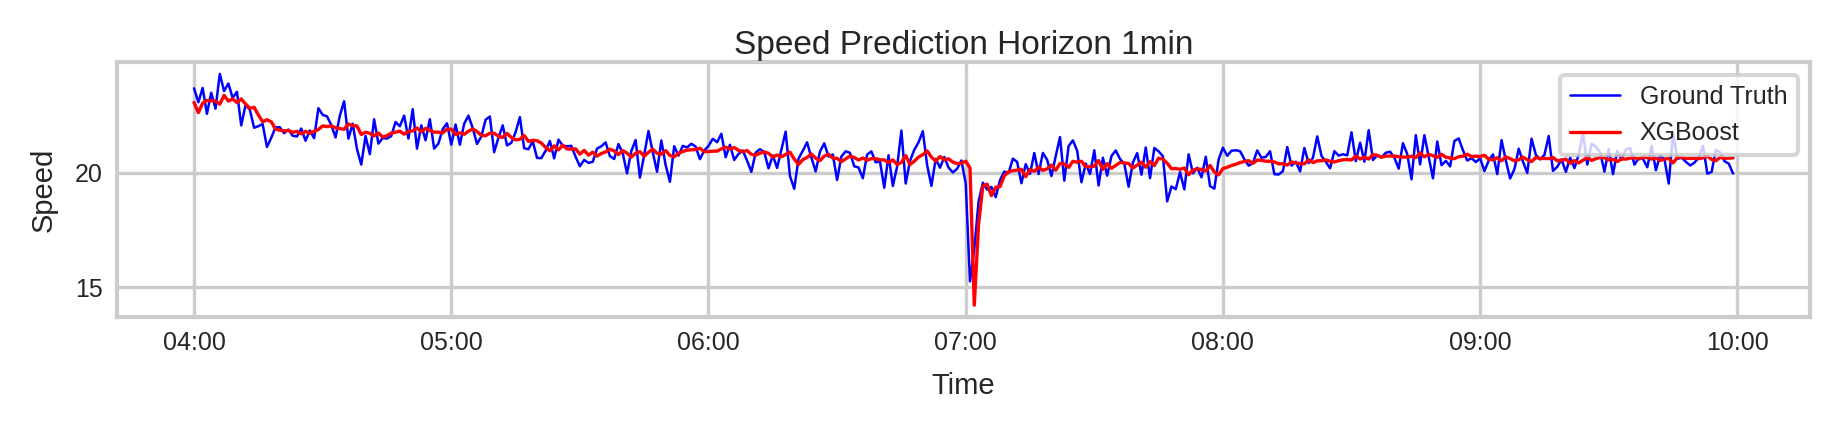

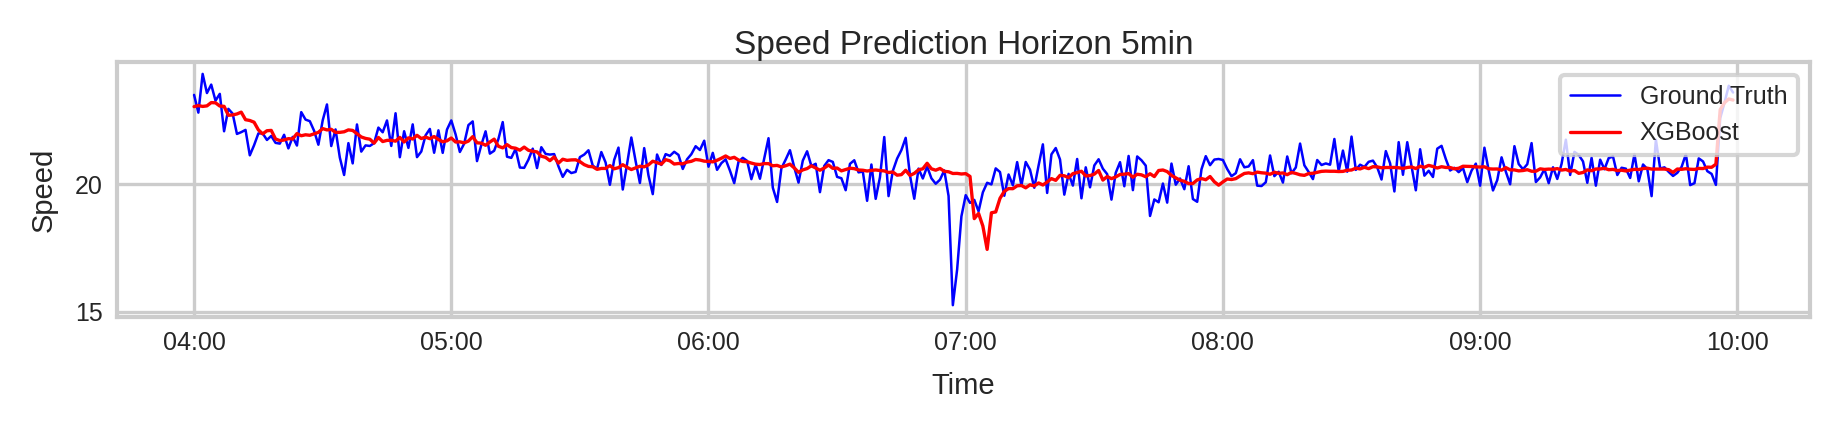

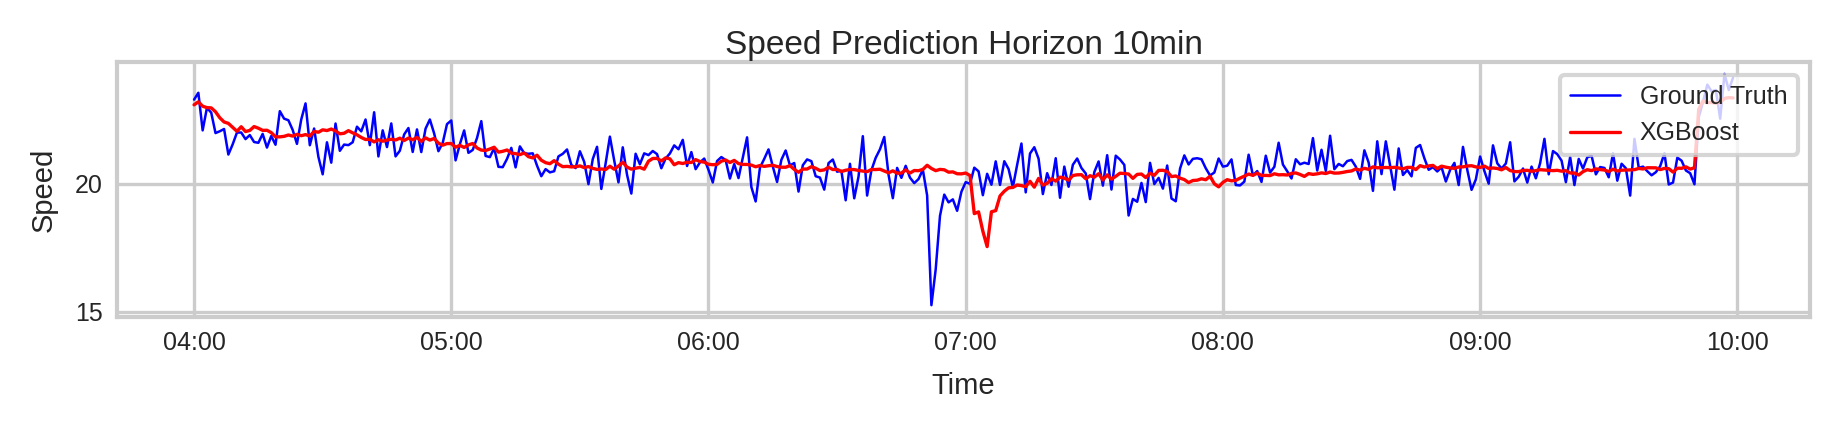

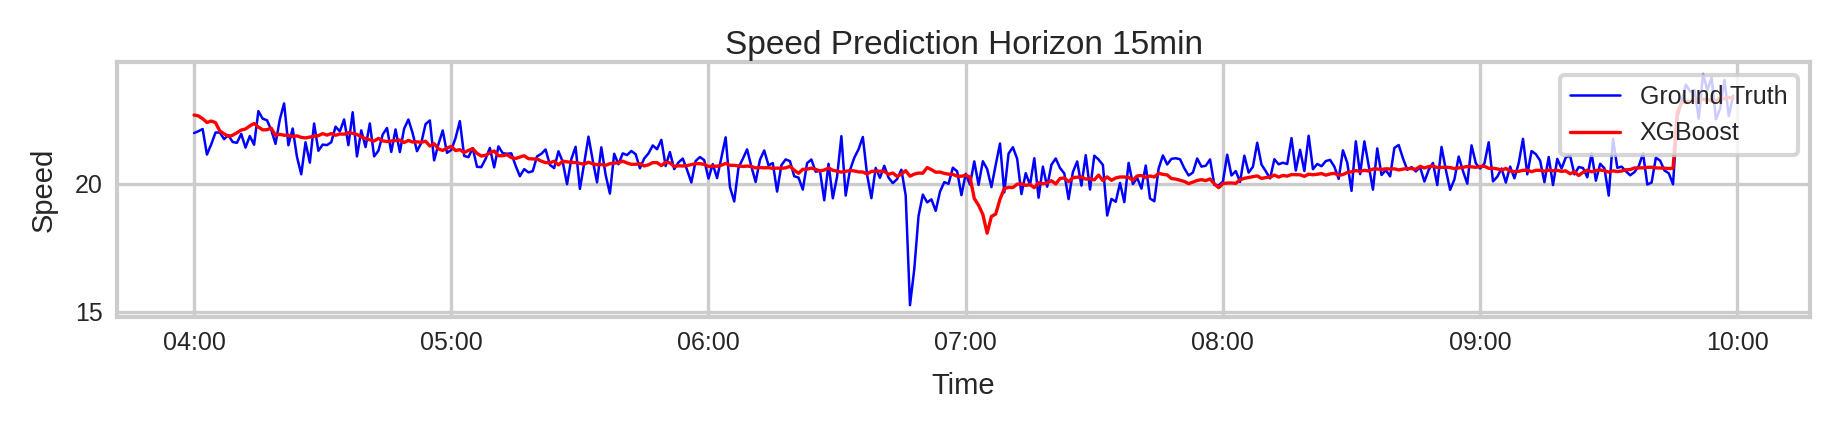

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator

H = [1, 5, 10, 15]
portal_id = "E4S 56,160"

for h in H:
    df = speed_pairs[h]
    df = df[df["PORTAL"] == portal_id]

    # random day
    mask = (df["datetime"] >= "2022-04-20 04:00:00") & (df["datetime"] < "2022-04-20 10:00:00")
    df_sub = df.loc[mask]

    plt.figure(figsize=(6, 1.3), dpi=300)
    plt.plot(df_sub["datetime"], df_sub[f"SPEED_MS_AVG_t+{h}"].values, label="Ground Truth", linewidth=0.6, color="blue")
    plt.plot(df_sub["datetime"], df_sub[f"pred_t+{h}"].values, label="XGBoost", linewidth=0.8, color="red")

    plt.ylabel("Speed", fontsize=7)
    plt.xlabel("Time", fontsize=7)
    plt.yticks(fontsize=6)

    plt.gca().xaxis.set_major_locator(HourLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(DateFormatter("%H:%M"))
    plt.xticks(fontsize=6, rotation=0)

    plt.legend(fontsize=6, loc="upper right", frameon=True)
    plt.title(f"Speed Prediction Horizon {h}min", fontsize=8, pad=2)

    plt.tight_layout(pad=0.2)
    plt.show()